As result of data gathering I have dataset with more than 6000 unique flats posted.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import datetime
import re

fname = 'Flat-rent-Prices-In-Palma\\'

In [ ]:
dtype = {
            'Area': str,
            'Bedrooms': str,
            'City': str,
            'Flat': str,
            'Flat_Det': str,
            'Floor and other details': str,
            'Id': str,
            'Link': str,
            'Price': str,
            'Square': str,
            'Street': str,
}
all_data = pd.read_csv(f'{fname}flatsDataset.csv', sep=';',encoding='latin1', dtype=dtype)

Checking how many flats stayed on the website longer that one day, as well, as those which stayed just one day:

In [ ]:
mt1 = all_data['Id'].value_counts()[all_data['Id'].value_counts()>1].count()
unq = all_data['Id'].nunique()
print(f''' 
There are: {mt1} that stayed more than one day
{unq} unique flats that has been posted, and {unq - mt1} that stayed just one day
''')

Now I will need to clean dataset, creating features DateFrom and DateTo. Also, I will filter out some outliers for analysis, as for some days gathering script hasn't been run.

In [ ]:
all_data = all_data.drop(['Unnamed: 0', 'Flat_Det'], axis=1)
all_data['Id'] = [re.sub('[!/?#]', '', x) for x in all_data['Id']]

In [ ]:
# creating a master list with only master data for flats
master = all_data[['Id']].drop_duplicates()

In [ ]:
date_from = all_data.groupby(by=['Id'], as_index=False, squeeze=False)['Timestamp'].min()
date_to = all_data.groupby(by=['Id'], as_index=False, squeeze=False)['Timestamp'].max()

In [ ]:
#merge two datasets together
ds = pd.merge(left=date_from, right=date_to, 
             how='inner', on='Id', suffixes=('_from', '_to'))
#merge dataset with initial one to get details
ds = pd.merge(left=ds, right=all_data, 
             how='left', left_on=['Id', 'Timestamp_to'], right_on=['Id', 'Timestamp'])

There some nan values in dataset, so I would drop them

In [30]:
ds = ds.dropna(thresh=4).reset_index(drop=True)
ds['Date_From'] = [datetime.datetime.strptime(ds['Timestamp_from'][i], '%Y-%m-%d %H:%M:%S').date() for i in range(0, len(ds['Timestamp_from']))]
ds['Date_To'] = [datetime.datetime.strptime(ds['Timestamp_to'][i], '%Y-%m-%d %H:%M:%S').date() for i in range(0, len(ds['Timestamp_to']))]

In [53]:
#Excluding outliers, start and end date, as well, as some dates in the middle where to html code was changed
ds = ds[(ds['Date_From']!=min(ds.Date_From))&
        (ds['Date_From']!=max(ds.Date_From))&
        (ds['Date_From']!=datetime.datetime.strptime('2018-01-09', '%Y-%m-%d').date())&
        (ds['Date_From']!=datetime.datetime.strptime('2017-12-14', '%Y-%m-%d').date())&
        (ds['Date_From']!=datetime.datetime.strptime('2018-01-31', '%Y-%m-%d').date())]
X = ds[['Id','Date_From']].groupby(['Date_From'], as_index = False).count()

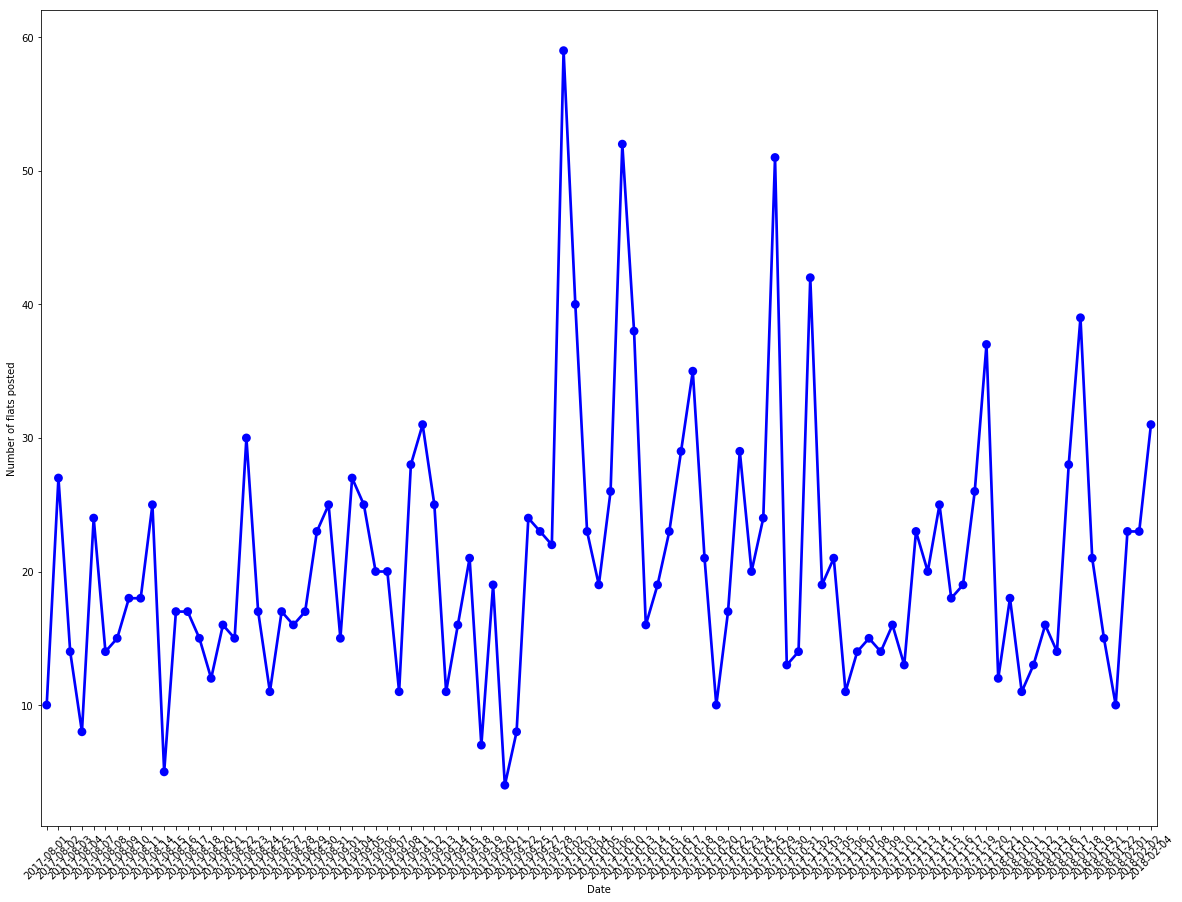

In [50]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(111)
sns.pointplot(x = 'Date_From', y = 'Id' ,data = X, ax = ax1, color = 'blue', join = True)
plt.xticks(rotation = 45)
plt.xlabel("Date")
plt.ylabel("Number of flats posted")
plt.show()

Goverment changes has been announced in July and announced in early August (https://majorcadailybulletin.com/news/local/2017/08/10/48821/owners-start-cancel-apartment-rental-bookings.html)

Graph above shows that number of flats started to increase since middle of August. To check it, implementing moving average

In [ ]:
ma = pd.rolling_mean(arg = X, window=10, min_periods = 1)

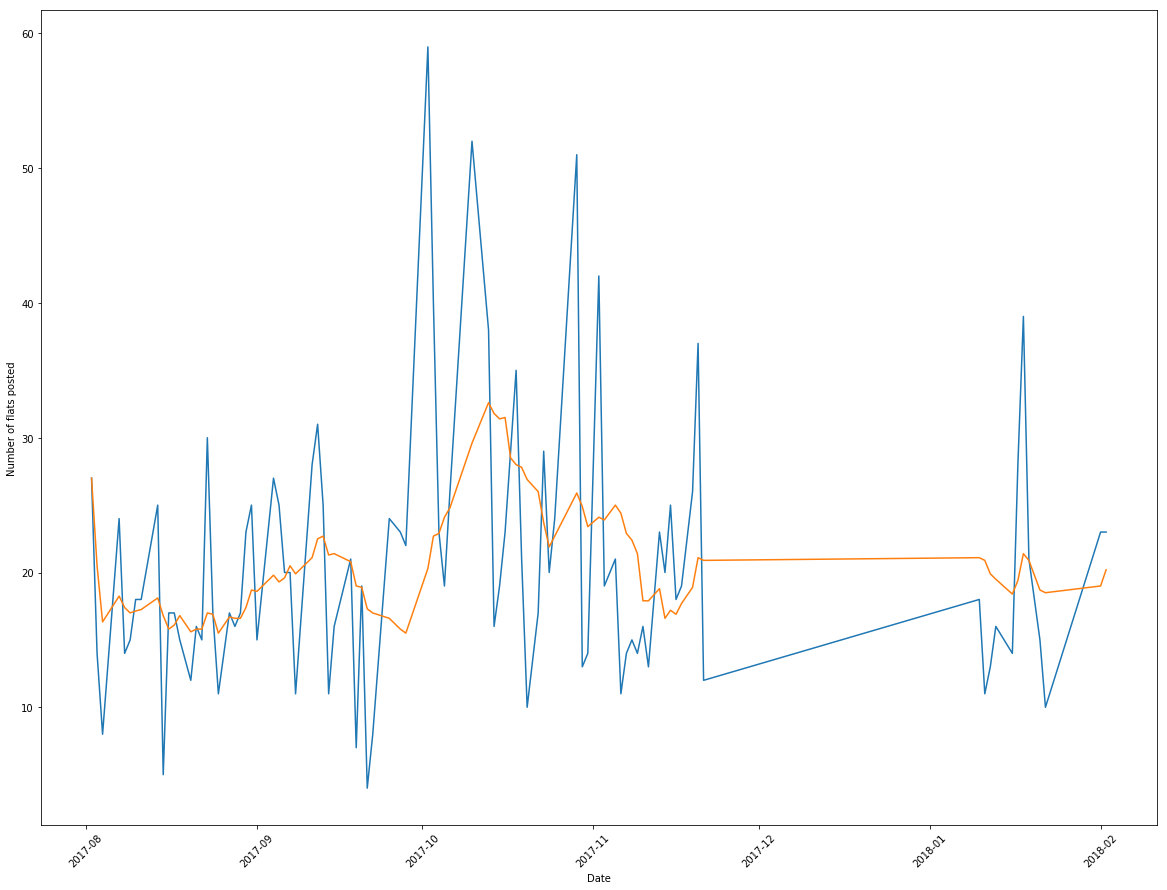

In [114]:
fig2 = plt.figure(figsize=(20, 15))
ax2 = fig2.add_subplot(111)
plt.plot(X['Date_From'], X['Id'], ma['Date_From'], ma['Id'])
plt.xticks(rotation = 45)
plt.xlabel("Date")
plt.ylabel("Number of flats posted")
plt.show()

Moving average graph shows that, indeed, number of flats advertised started to increase. However it could be related with seasonality.

** Coming to prices **

In [60]:
ds['Bedrooms'] = ds['Bedrooms'].astype(str) #to align first
ds['Bedrooms'] = ds.Bedrooms.str.extract('(\d)').astype(int)
ds['Price'] = ds['Price'].astype(float)
print(ds[['Date_From', 'Bedrooms', 'Price']].groupby(['Date_From','Bedrooms'], as_index = False).mean())


      Date_From  Bedrooms        Price
0    2017-08-02         1   749.000000
1    2017-08-02         2   914.444444
2    2017-08-02         3   903.000000
3    2017-08-02         4  1833.333333
4    2017-08-03         1   749.000000
5    2017-08-03         2   873.333333
6    2017-08-03         3   813.333333
7    2017-08-04         2  1383.333333
8    2017-08-04         3   945.000000
9    2017-08-04         4  1200.000000
10   2017-08-07         1   683.333333
11   2017-08-07         2   779.500000
12   2017-08-07         3  1266.666667
13   2017-08-07         4  1360.000000
14   2017-08-08         1   900.000000
15   2017-08-08         2   850.000000
16   2017-08-08         3   903.000000
17   2017-08-08         4  2350.000000
18   2017-08-09         1   700.000000
19   2017-08-09         2   758.333333
20   2017-08-09         3   960.000000
21   2017-08-09         4   800.000000
22   2017-08-10         0   750.000000
23   2017-08-10         1   650.000000
24   2017-08-10         2

C:\Users\maksim.lebedev\AppData\Local\Continuum\anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


For analysis purposes I will exclude those flats with numbers of bedrooms bigger than 3. Will be calculating average price for every day, grouping it by bedroom number.

**Average price** is calculated taking into account only those flats, that has been added on that particular day. That's why prices for 2017-07-24 could be low due to number of flats available on the website (I started load at 27/07). I believe that this should give better view on "how" agencies or owners are setting prices.

In [ ]:
pr_max_3 = ds[ds['Bedrooms']<=3]
X_pr = pr_max_3.groupby(['Date_From','Bedrooms'], as_index = False)['Price'].mean()
ma0 = pd.rolling_mean(arg=X_pr, window=10, min_periods=1)

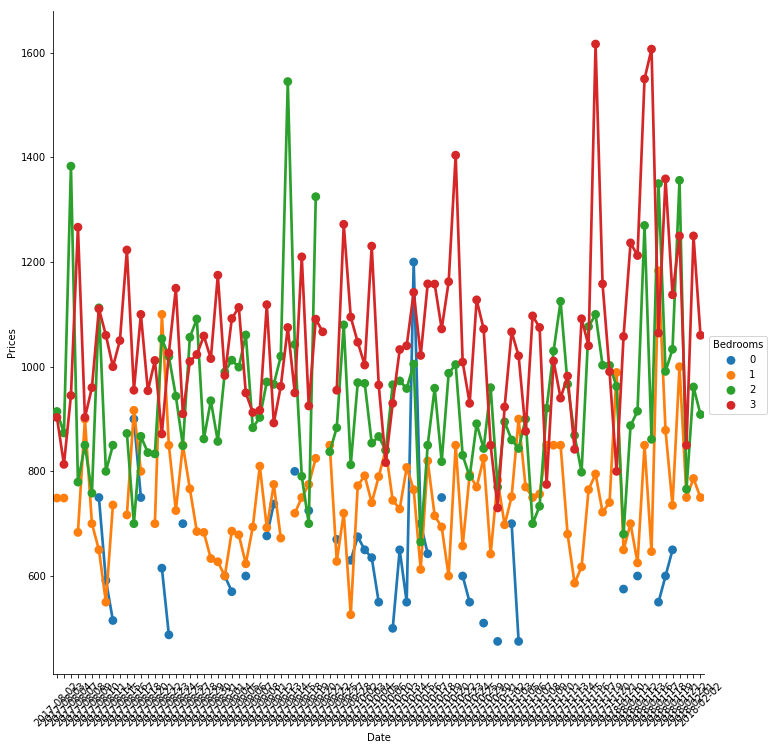

In [113]:
#visualizing it
sns.factorplot("Date_From","Price", hue ="Bedrooms", data = X_pr, size = 10, legend = True)
plt.xticks(rotation = 45)
plt.xlabel("Date")
plt.ylabel("Prices")
plt.show()

As result - we could see that there is no decreasing trend in pricing, meaning that owners and agencies didn't change their 'habbits' yet. However, as shown above - there are more flats available on the market.
As next steps:
1. Collect more data to check seasonality factor (it should be strong);
2. Evaluate 'time on the site' metric, which will allow to understand - how big is demand (many agencies aren't updating their pageson the website, this behaviour will make metric not accurate);
3. Add description field into extraction.

**Updated on 13 of April.**
All the graphs are update with the new information, plus I added a process of data cleansing.
As result - in fact, there is no decreasing trend in flat's prices, and as mentioned before, hike of offers was related more with a low season.
New feauture "Time on Site" is added below.


In [ ]:
ds = ds.reset_index(drop=True)
ds['Time_on_Site'] = np.NaN
for i in range(0, len(ds)):
    ds['Time_on_Site'][i] = ds['Date_To'][i] - ds['Date_From'][i]

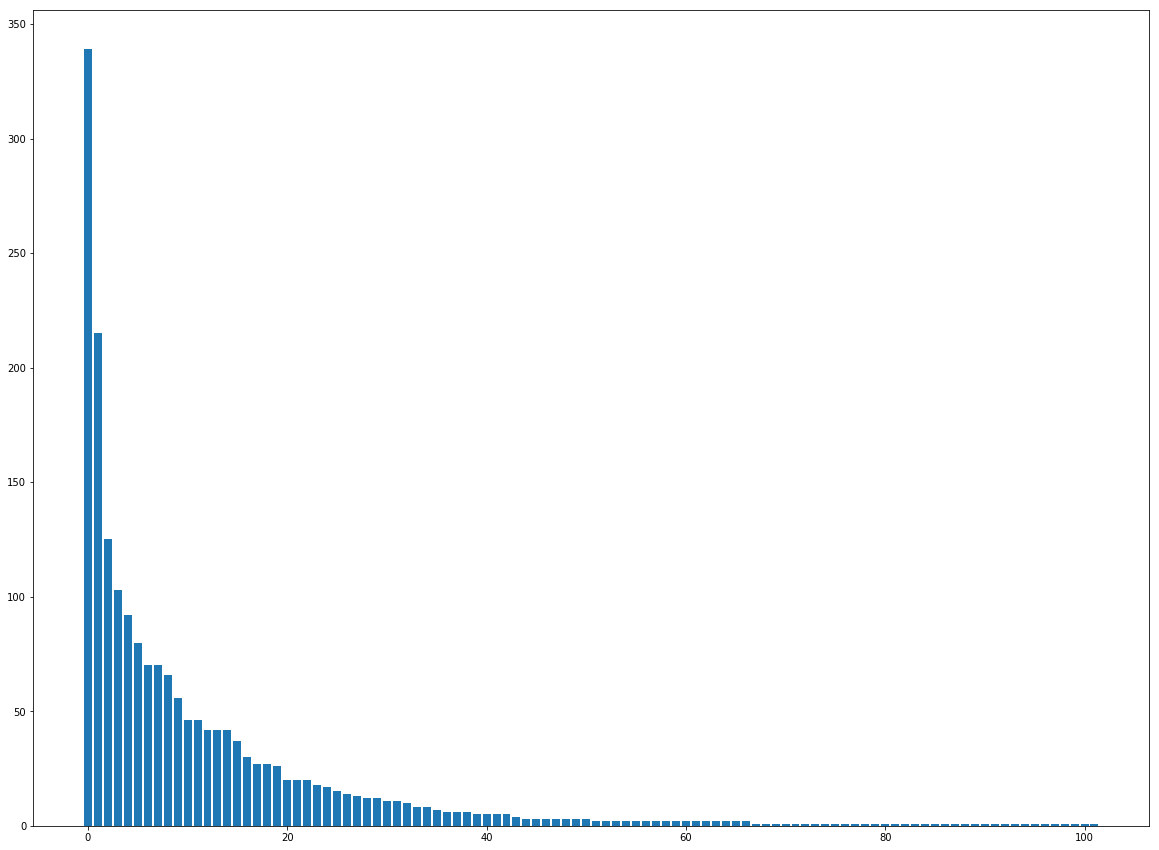

In [107]:
dim = ds['Time_on_Site'].value_counts().index
kf = ds['Time_on_Site'].value_counts().values
fig = plt.figure(figsize=(20, 15))
fig.add_subplot(111)
plt.bar(np.arange(len(dim)), kf)
plt.show()